# Importing Dependencies & extracting dataset
----
This part of the process deals with the _Extraction_ part of the ***E***TL. Firstly, the needed modules will be imported and then the dataset. 

In [33]:
import pandas as pd
import numpy as np
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

import seaborn as sns

In [3]:
### In case, one wanted to upload the files to a File Storage (in case Google Drive)
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [24]:
### Some commands to create directory structure and rename file
%cd /content/gdrive/My\ Drive
!rm -r projects
!mkdir projects
!mkdir projects/capstone
!mkdir projects/capstone/checkpoints
%cd /content/gdrive/My\ Drive/projects/capstone

In [22]:
!rm trainingandtestdata.zip -f
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip 
!unzip trainingandtestdata.zip
!mv training.1600000.processed.noemoticon.csv sentiment_analysis_trainingset.csv

URL transformed to HTTPS due to an HSTS policy
--2020-06-27 21:37:12--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  20.8MB/s    in 4.7s    

2020-06-27 21:37:18 (16.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


### About the dataset used
The [Sentiment140](http://help.sentiment140.com/for-students) was used base dataset. 

[Sentiment140](http://help.sentiment140.com/for-students) contains 1,600,000 tweets extracted using the twitter api, where the tweets have been tagged as:
* 0 = negative
* 2 = Neutral (though, none was founded in the training dataset)
* 4 = positive

and they can be used to detect sentiment. 

The [Sentiment140](http://help.sentiment140.com/for-students) dataset has 6 features, registred in the respectively, order:
- sentiment: the polarity of the tweet (`0` = negative, `2` = neutral, `4` = positive)
- ids: The id of the tweet (`2087`)
- date: the date of the tweet (`Sat May 16 23:58:44 UTC 2009`)
- query: The query (`lyx`). If there is no query, then this value is `NO_QUERY`.
- user: the user that tweeted (`robotickilldozr`)
- post: the text, content of the tweet (`Lyx is cool`)

Loading the dataset into Pandas framework:

In [25]:
nameColumns = ["sentiment", "id", "date", "query", "user", "post"]

fullDataset = pd.read_csv('sentiment_analysis_trainingset.csv', 
                          header=None, 
                          names=nameColumns, 
                          encoding='latin1', 
                          engine='python')

In [26]:
print(fullDataset.info())
print("The dataset has the following sentiment distribution:\n", pd.Series(fullDataset.sentiment).value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   post       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None
The dataset has the following sentiment distribution:
 4    800000
0    800000
Name: sentiment, dtype: int64


### Initial sampling
In order to gain time-efficiency, a random sample was extracted from the 1.6MM datapoints.


In [28]:
sampleDataset = fullDataset.sample(frac=0.1, replace = None, random_state=300)
sampleDataset.index = range(len(sampleDataset))
sampleDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  160000 non-null  int64 
 1   id         160000 non-null  int64 
 2   date       160000 non-null  object
 3   query      160000 non-null  object
 4   user       160000 non-null  object
 5   post       160000 non-null  object
dtypes: int64(2), object(4)
memory usage: 7.3+ MB


# Exploratory Data Analysis (EDA)
In this part, we will take a closer look at the data, while perfoming some data transformations (E***T***L).



## sentiments overview
In this section, we will take a closer look at the tweets sentiment. We will perform:
- tweets sentiment re-tag
- tweets sentiment distribution check


In [29]:
sampleDatasetLabels = sampleDataset.sentiment.values
sampleDatasetLabels[sampleDatasetLabels == 4] = 1

In [30]:
%matplotlib inline

### tweets sentiment distribution

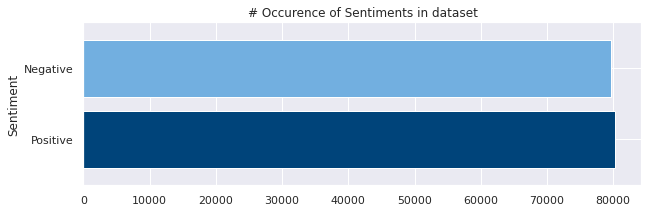


The dataset sample has the following sentiment distribution:
- 80262 Positive
- 79738 Negative

We have a balanced sample of both positive/negative-sentiment tweets


In [37]:
def SentimentFrequency():
  """
  : Plot sentiment frequency present in dataset
  """  
  D = pd.Series(sampleDatasetLabels).value_counts()
  
  fig, ax = plt.subplots(figsize=(10, 3))
  D.sort_values().sort_values(ascending=False).plot.barh(width=0.8, align='center', color=['#00447a', '#72afe0'])
  ax.set(title='# Occurence of Sentiments in dataset')
  ax.set(ylabel='Sentiment')
  ax.set(yticklabels=['Positive', 'Negative'])
  plt.show()

  print("\nThe dataset sample has the following sentiment distribution:\n- {0} Positive\n- {1} Negative".format(D[1], D[0]))
  if 0.4 <= D[0]/(D[0] + D[1]) <= 0.6: 
    print("\nWe have a balanced sample of both positive/negative-sentiment tweets")
  else:
    print("\nIt seems our sample has not a balanced distribution of both positive/negative-sentiment tweets")

SentimentFrequency()

## tweets overview
This subsection takes a closer look at the tweets text. We will perform: 
- text treatment
- tweet's length distributions (before and after treatment)
- word frequency and visualization
- bigrams frequency and visualization


In [38]:
for _ in range(100):
    print(sampleDataset.post[_])

Haha someones super happy today! 
@strawz because multiple coloured hair is just that trendy and awesome 
@Bullpigology101 oh.. if it was near your mom's i'd of said we should go!..but its not.. 
Okay someone explain this october TH thing to me I am at work. Not near a computer 
@ladygaga you never ceases to amaze me. paparazzi video is SO the best of the year and EPIC! 
Well I'll be off for a bit gonna get out of my stuffy uniform and get me headache tablets too Tweet ya later 
- packing up to come home from Muskegon. I had a lot of fun but this sunburn is killing me. 
@aazzure LOL!!! I promise not to report you on this side of the galaxy! It's the other side that is giving me so much damned trouble! 
@iveeanne im just really tired ! I don't have a headacke or anythg so everythg is good! I had some fun last night! 
@AlexAllTime I asked Jack but he didnt reply  so I'm gonna ask you. Are you guys gonna have a signing in Melbourne? 
On my way to work... Boo 
@staceemcfly eee dear god sta

> Looking at the sample above, we notice how irregular Twitter posts can be. Different from a _e.g._ news article, or a book chapter, Twitter posts are way more informal and _freely-written_, which means words do not need to follow any sort of grammar and any other language convention.
>
> This poses a challenge for Sentiment Analysis when computer learns from social media:
- abbreviations: `y`, `u`, `y r`, `anythg`, `everythg`
- (un)intentionally spelling errors: `underxposed`, `unfortunetly` 
- intensity: `byeeeeeeeee`, `youuuuu`, `morniiiiiinnnnggg`




That being said, in the next step we will treat the tweets text, to remove all sort of noise and non-essencial for our analysis:

In [39]:
def TweetTreament(stringTweet):
  """
  : tweet text treament removing noise from text
  : stringTweet: string object containing the tweet
  """

    tweet = re.sub(r"https?://[a-zA-Z0-9./]+", ' ', stringTweet)  # remove the URL links
    tweet = re.sub(r"(w|W){3}[a-zA-Z0-9./]+", ' ', tweet)         # remove the www references
    tweet = re.sub(r"@[a-zA-Z0-9]+", ' ', tweet)                  # remove references from accounts/profiles, using @ 
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)                  # keep only letters & punctuations marks
    tweet = re.sub(r" +", ' ', tweet).strip()                     # remove potential excess of whitespaces before, in and after
    
    return tweet

In [40]:
positiveTweets = sampleDataset.post[sampleDatasetLabels == 1]
negativeTweets = sampleDataset.post[sampleDatasetLabels == 0]

cleanedTweets = [TweetTreament(t) for t in sampleDataset.post]
cleanedPositiveTweets = [TweetTreament(t) for t in positiveTweets]
cleanedNegativeTweets = [TweetTreament(t) for t in negativeTweets]

### tweets length distribution

Looking at the Tweet's length distributions below, we can see that the text treament only remove non-essencial information. We see no significant change in Tweets distributions before and after the treatment.  

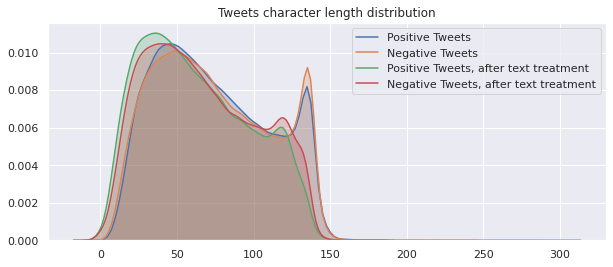


Tweets median lenght are, before treatment, 69.0 characters for positive Tweets and 70.0 characters for negative Tweets

Tweets median lenght are, after treatment, 58.0 characters for positive Tweets and 62.0 characters for negative Tweets



In [41]:
def TweetDistribution():
  """
  : function to plot the distribution of tweets in terms of lenght.
  """
  positiveCleanedLength = np.array([len(p) for p in cleanedPositiveTweets])
  negativeCleanedLength = np.array([len(p) for p in cleanedNegativeTweets])
  positiveLength = np.array([len(p) for p in positiveTweets])
  negativeLength = np.array([len(p) for p in negativeTweets])

  fig, ax = plt.subplots(figsize=(10,4))
  plt.title('Tweets character length distribution')
  sns.kdeplot(positiveLength, shade=True, bw=3.5, label="Positive Tweets", cut=5)
  sns.kdeplot(negativeLength, shade=True, bw=3.5, label="Negative Tweets", cut=5)
  sns.kdeplot(positiveCleanedLength, shade=True, bw=3.5, label="Positive Tweets, after text treatment", cut=5)
  sns.kdeplot(negativeCleanedLength, shade=True, bw=3.5, label="Negative Tweets, after text treatment", cut=5)
  plt.show()

  print("\nTweets median lenght are, before treatment, {0} characters for positive Tweets and {1} characters for negative Tweets\n"\
        .format(np.median((positiveLength)),np.median((negativeLength))))

  print("Tweets median lenght are, after treatment, {0} characters for positive Tweets and {1} characters for negative Tweets\n"\
        .format(np.median((positiveCleanedLength)),np.median((negativeCleanedLength))))

TweetDistribution()

### word frequency (word cloud)

For visualization, we will plot some of the most frequent word both in negative and positive-sentiment tweets. 

We will focus only in the most frequent word in a sentiment group, removing potential frequent words that appears in both sentiment group:


In [43]:
def WordFrequency(stringOb):
  """
  : Define the frequency in a string or list of string elements 
  : type stringOb: string or list of strings
  : rtype: pd.Series object
  """    
  if type(stringOb) == str:
    return (pd.Series(re.sub(r"[.?!]", '', stringOb).lower().strip().split(' '))).value_counts()
  elif type(stringOb) == list:
    listWord = []
    for post in stringOb:
      listWord += re.sub(r"[.?!]", '', post).lower().strip().split(' ')
    return (pd.Series(listWord)).value_counts()
  else:
    raise ValueError('stringOb must be a list or string-type')

positiveWords = WordFrequency(cleanedPositiveTweets)
negativeWords = WordFrequency(cleanedNegativeTweets)

there are 103 exclusively positive words and 103 exclusively negative words in each word cloud



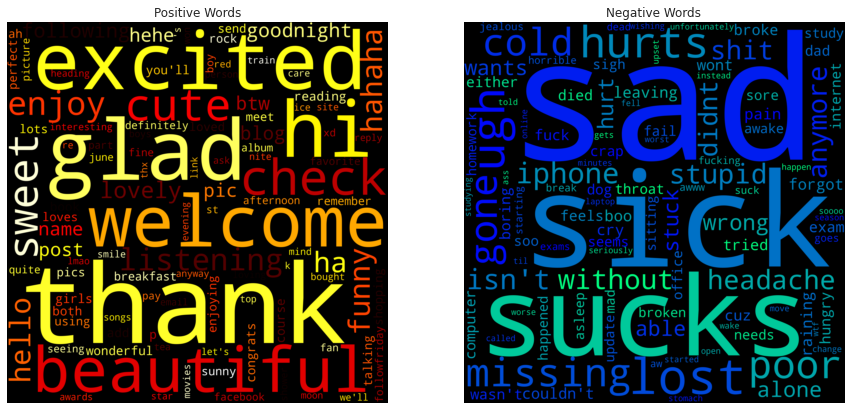

In [44]:
def PlotWordCloud(n):
  """
  : plot Word Clouds 
  : type n: int
  : rtype: chart 
  """   
  positiveCloud = {w:v for w,v in positiveWords[:n].to_dict().items() if w not in negativeWords[:n].to_dict().keys()}
  negativeCloud = {w:v for w,v in negativeWords[:n].to_dict().items() if w not in positiveWords[:n].to_dict().keys()}
  
  print("there are {0} exclusively positive words and {1} exclusively negative words in each word cloud\n"\
        .format(len(positiveCloud), len(negativeCloud)))

  pos = WordCloud(width = 2400, height = 2400, 
                background_color ='black', min_font_size = 7, 
                colormap=plt.cm.hot).generate_from_frequencies(positiveCloud)

  neg = WordCloud(width = 2400, height = 2400, 
                background_color ='black', min_font_size = 7, 
                colormap=plt.cm.winter).generate_from_frequencies(negativeCloud)

  f, axs = plt.subplots(1,2,figsize=(15,15))
  axs[0].imshow(pos, interpolation="bilinear")
  axs[0].axis('off')
  axs[0].title.set_text('Positive Words')
  axs[1].imshow(neg, interpolation="bilinear")
  axs[1].axis('off')
  axs[1].title.set_text('Negative Words')
  plt.show()

PlotWordCloud(540)

### _bigrams_ frequency

Here, we take a look at the most frequent _bi-grams_. Bi-grams, or n-grams of size 2, are just a sequence of words. Whenever in a sentence, twos words are next each other, they form a bi-gram.

In [45]:
def BigramsFrequency(stringOb):
  """
  : Calculate the bigram frquency 
  : type stringOb: string or list of strings
  : rtype: pd.Series object 
  """     
  from nltk.util import bigrams
  if type(stringOb) == str:
      return pd.Series(bigrams(re.sub(r"[.?!]", '', stringOb).lower().strip().split(' '))).value_counts()
  elif type(stringOb) == list:
      listWord = []
      for post in stringOb:
          listWord += bigrams(re.sub(r"[.?!]", '', post).lower().strip().split(' '))
      return pd.Series(listWord).value_counts()
  else:
      raise ValueError('stringOb must be a list or string-type')

positiveBigrams = BigramsFrequency(cleanedPositiveTweets)
negativeBigrams = BigramsFrequency(cleanedNegativeTweets)

In [46]:
print('The 20 most common positive Bigrams\n', positiveBigrams[:20])
print('The 20 most common negative Bigrams\n', negativeBigrams[:20])

The 20 most common positive Bigrams
 (for, the)       2245
(in, the)        2216
(i, love)        2201
(going, to)      2033
(on, the)        1644
(have, a)        1609
(i, am)          1540
(i, have)        1470
(to, the)        1383
(of, the)        1338
(thank, you)     1301
(to, be)         1251
(i, think)       1219
(to, see)        1122
(thanks, for)    1111
(a, good)        1038
(at, the)        1035
(and, i)         1006
(you, are)        997
(for, a)          975
dtype: int64
The 20 most common negative Bigrams
 (i, have)      3013
(in, the)      2393
(going, to)    2187
(have, to)     2061
(to, go)       2038
(i, am)        1885
(i, was)       1853
(but, i)       1737
(i, don't)     1727
(to, be)       1706
(and, i)       1685
(i, miss)      1677
(want, to)     1606
(to, the)      1521
(on, the)      1484
(i, can't)     1472
(i, want)      1455
(go, to)       1403
(wish, i)      1350
(to, get)      1325
dtype: int64


For visualization purpose, we will again focus only in the most frequent bigrams in a sentiment group, that do not appear in the other sentiment group:

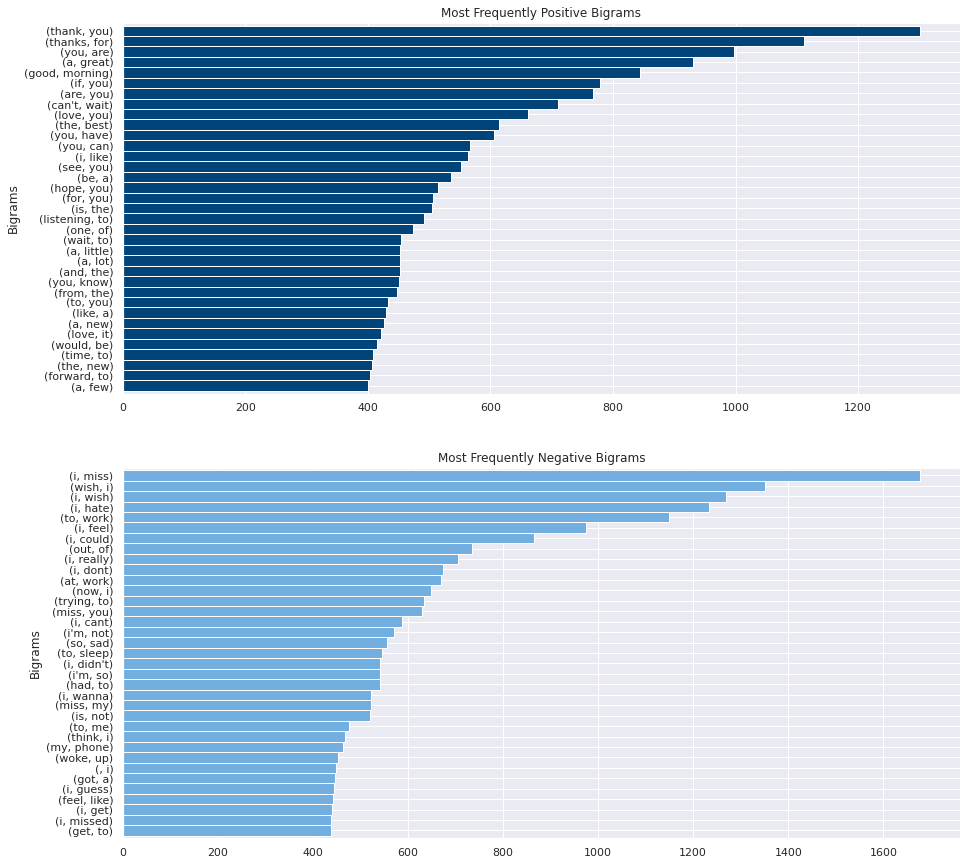

In [51]:
def PlotBigram(n):
  """
  : Plot the most frequent BIgrams 
  : type n: int
  : rtype: charts 
  """  
  positiveBig = {w:v for w,v in positiveBigrams[:100].to_dict().items() if w not in negativeBigrams[:100].to_dict().keys()}
  negativeBig = {w:v for w,v in negativeBigrams[:100].to_dict().items() if w not in positiveBigrams[:100].to_dict().keys()}

  fig, ax = plt.subplots(2,1, figsize=(15, 15)) 

  pd.Series(positiveBig).sort_values().plot.barh(ax=ax[0], width=1, align='center', color='#00447a')
  ax[0].set(title='Most Frequently Positive Bigrams')
  ax[0].set(ylabel='Bigrams')  
 
  pd.Series(negativeBig).sort_values().plot.barh(ax=ax[1], width=1, align='center', color='#72afe0')
  ax[1].set(title='Most Frequently Negative Bigrams')
  ax[1].set(ylabel='Bigrams')  
 
PlotBigram(500)